In [1]:
from pycbc import distributions
from pycbc.waveform import get_td_waveform
from pycbc.filter import sigma
from pycbc.psd import aLIGOZeroDetHighPower
import pycbc.noise
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
from gwpy.timeseries import TimeSeries
import os

# Parameters
n_samples = 5000
start_times_bbh = [2]

# Mass distribution
bbh_two_mass_distributions = distributions.Uniform(mass1=(10, 50), mass2=(10, 50))
bbh_two_mass_samples = bbh_two_mass_distributions.rvs(size=n_samples)

# Directories
base_dir = "C:/Users/sunda/Documents/Github/Gravitational Wave Detection/scripts/raw-data-files-enhanced-data-generation/"
dirs = {
    "signal": os.path.join(base_dir, "BBH/"),
    "noise": os.path.join(base_dir, "noise_template/"),
    "injected": os.path.join(base_dir, "noise-injected-signal/")
}
for d in dirs.values():
    os.makedirs(d, exist_ok=True)

# Injection loop
valid_count = 0
max_attempts = 10000  # safety
i = 0
while valid_count < 5000 and i < max_attempts:
    try:
        m1, m2 = np.random.uniform(10, 50, size=2)
        target_snr = np.random.randint(8, 15)

        # Generate waveform
        hp, _ = get_td_waveform(approximant="SEOBNRv2",
                                mass1=m1,
                                mass2=m2,
                                delta_t=1.0 / 4096,
                                f_lower=40)

        # PSD for sigma
        delta_f_sigma = 1.0 / hp.duration
        flen_sigma = int(2048 / delta_f_sigma) + 1
        psd_sigma = aLIGOZeroDetHighPower(flen_sigma, delta_f_sigma, 30.0)
        psd_sigma[psd_sigma == 0] = 1e-40
        psd_sigma = pycbc.types.FrequencySeries(psd_sigma, delta_f=delta_f_sigma)

        # Calculate original SNR
        ht = hp.to_frequencyseries()
        snr_before = sigma(ht, psd=psd_sigma, low_frequency_cutoff=40)

        if not np.isfinite(snr_before) or snr_before == 0:
            i += 1
            continue

        # Scale
        hp *= target_snr / snr_before

        # Inject into noise
        delta_t = 1.0 / 4096
        tsamples = int(4 / delta_t)
        delta_f_noise = 1.0 / 4.0
        flen_noise = int(2048 / delta_f_noise) + 1
        psd_noise = aLIGOZeroDetHighPower(flen_noise, delta_f_noise, 30.0)
        noise = pycbc.noise.noise_from_psd(tsamples, delta_t, psd_noise)
        noise = TimeSeries.from_pycbc(noise)

        # Create signal time series
        bbh_signal = TimeSeries.from_pycbc(hp)
        bbh_signal.t0 = 2  # center injection

        # Inject
        injected = noise.inject(bbh_signal)

        # Save
        bbh_signal.write(dirs["signal"] + f"bbh_4k_{valid_count}.txt")
        injected.write(dirs["injected"] + f"merged_noise_signal_{valid_count}.txt")
        valid_count += 1

    except Exception as e:
        # Optional debug print
        print(f"Skipping sample {i}: {e}")

    i += 1

if valid_count < 5000:
    print(f"⚠️ Only generated {valid_count} samples after {max_attempts} attempts.")

/usr/local/lib/python3.8/dist-packages/pycbc/types/array.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal as _lal
/usr/local/lib/python3.8/dist-packages/pycbc/scheme.py:194: RuntimeWarning: divide by zero encountered in divide
  return _import_cache[mgr.state][func](*args, **kwds)
/usr/local/lib/python3.8/dist-packages/pycbc/scheme.py:194: RuntimeWarning: invalid value encountered in divide
  return _import_cache[mgr.state][func](*args, **kwds)


In [2]:
from pycbc import distributions
from pycbc.waveform import get_td_waveform
from pycbc.filter import sigma
from pycbc.psd import aLIGOZeroDetHighPower
import pycbc.noise
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
from gwpy.timeseries import TimeSeries
import os

for i in tqdm(range(5000)):
    
    # The color of the noise matches a PSD which you provide
    flow = 30.0
    delta_f = 1.0 / 4
    flen = int(2048 / delta_f) + 1
    psd = pycbc.psd.aLIGOZeroDetHighPower(flen, delta_f, flow)

    # Generate 4 seconds of noise at 4096 Hz
    delta_t = 1.0 / 4096
    tsamples = int(4 / delta_t)
    noise = pycbc.noise.noise_from_psd(tsamples, delta_t, psd)

    noise = TimeSeries.from_pycbc(noise)

    noise.write(base_dir+"/noise_template/noise_4k_"+str(i)+".txt")

  0%|          | 0/5000 [00:00<?, ?it/s]

In [3]:
from pycbc import distributions
from pycbc.waveform import get_td_waveform
from pycbc.filter import sigma
from pycbc.psd import aLIGOZeroDetHighPower
import pycbc.noise
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
from gwpy.timeseries import TimeSeries
import os


# --- Parameters ---
n_val_samples = 1000
fs = 4096
duration = 4.0
delta_t = 1.0 / fs
tsamples = int(duration * fs)
start_times = [2]
flow = 30.0

# --- Directories ---
val_dir = "C:/Users/sunda/Documents/Github/Gravitational Wave Detection/scripts/raw-val-data-files-enhanced-data-generation/"
dirs = {
    "noise": os.path.join(val_dir, "noise"),
    "injected": os.path.join(val_dir, "injected")
}
for d in dirs.values():
    os.makedirs(d, exist_ok=True)

# --- Mass distribution ---
mass_dist = distributions.Uniform(mass1=(10, 50), mass2=(10, 50))
mass_samples = mass_dist.rvs(size=n_val_samples)

# --- Validation generation loop ---
for i in tqdm(range(n_val_samples), desc="Generating validation data"):
    # Random target SNR
    target_snr = np.random.randint(8, 15)

    # Generate waveform
    hp, _ = get_td_waveform(approximant="SEOBNRv2",
                            mass1=mass_samples[i][0],
                            mass2=mass_samples[i][1],
                            delta_t=delta_t,
                            f_lower=40)

    # PSD for sigma scaling
    delta_f_sigma = 1.0 / hp.duration
    flen_sigma = int(2048 / delta_f_sigma) + 1
    psd_sigma = aLIGOZeroDetHighPower(flen_sigma, delta_f_sigma, flow)

    # Scale waveform to target SNR
    ht = hp.to_frequencyseries()
    snr_original = sigma(ht, psd=psd_sigma, low_frequency_cutoff=40)
    hp *= target_snr / snr_original

    # Convert to TimeSeries and apply time offset
    bbh_ts = TimeSeries.from_pycbc(hp)
    bbh_ts.t0 = np.random.choice(start_times)

    # PSD for 4s noise generation
    delta_f_noise = 1.0 / duration
    flen_noise = int(2048 / delta_f_noise) + 1
    psd_noise = aLIGOZeroDetHighPower(flen_noise, delta_f_noise, flow)

    # Generate pure noise
    noise = pycbc.noise.noise_from_psd(tsamples, delta_t, psd_noise)
    noise = TimeSeries.from_pycbc(noise)

    # Save pure noise
    noise.write(f"{dirs['noise']}/val_noise_{i}.txt")

    # Inject signal into noise
    injected = noise.inject(bbh_ts)

    # Save injected signal + noise
    injected.write(f"{dirs['injected']}/val_injected_{i}.txt")


Generating validation data:   0%|          | 0/1000 [00:00<?, ?it/s]

In [4]:
import csv
import pandas as pd

In [5]:
#Merging the injected signal into single CSV file
path = "C:/Users/sunda/Documents/Github/Gravitational Wave Detection/scripts/raw-data-files-enhanced-data-generation/noise-injected-signal/"
files= os.listdir(path)
f = open("C:/Users/sunda/Documents/Github/Gravitational Wave Detection/scripts/raw-data-files-enhanced-data-generation/Final_BBH_Merged_Noise_Signal_Reduced_No_ABS.csv", 'w')
cw = csv.writer(f)

for i in tqdm(files):
    df = pd.read_csv(path+i,sep = ' ', header=None)
    c = df[:][1]
    cw.writerow(c)
f.close()

  0%|          | 0/5000 [00:00<?, ?it/s]

In [6]:
#Merging the noise into single CSV file
path = "C:/Users/sunda/Documents/Github/Gravitational Wave Detection/scripts/raw-data-files-enhanced-data-generation/noise_template/"
files= os.listdir(path)
f = open("C:/Users/sunda/Documents/Github/Gravitational Wave Detection/scripts/raw-data-files-enhanced-data-generation/Final_Merged_Noise_Reduced_No_Abs.csv", 'w')
cw = csv.writer(f)

for i in tqdm(files):
    df = pd.read_csv(path+i,sep = ' ', header=None)
    if 1 in df.columns:
        c = df[1]
    else:
        c = df[0]
    #c = df[:][1]
    cw.writerow(c)
f.close()

  0%|          | 0/5000 [00:00<?, ?it/s]

In [7]:
#Merging the signal into single CSV file
path = "C:/Users/sunda/Documents/Github/Gravitational Wave Detection/scripts/raw-data-files-enhanced-data-generation/BBH/"
files= os.listdir(path)
f = open("C:/Users/sunda/Documents/Github/Gravitational Wave Detection/scripts/raw-data-files-enhanced-data-generation/Final_Merged_bbh_Signal_Reduced_No_Abs.csv", 'w')
cw = csv.writer(f)

for i in tqdm(files):
    df = pd.read_csv(path+i,sep = ' ', header=None)
    c = df[:][1]
    cw.writerow(c)
f.close()

  0%|          | 0/5000 [00:00<?, ?it/s]

In [8]:
path = val_dir+"injected/"
files= os.listdir(path)
f = open(val_dir+'val_Final_BBH_Merged_Noise_Signal_Reduced_No_ABS.csv', 'w')
cw = csv.writer(f)

for i in tqdm(files):
    df = pd.read_csv(path+i,sep = ' ', header=None)
    c = df[:][1]
    cw.writerow(c)
f.close()

  0%|          | 0/1000 [00:00<?, ?it/s]

In [9]:
path_1 = val_dir+"noise/"
files_1= os.listdir(path_1)
f1 = open(val_dir+'val_Final_Merged_Noise_Reduced_No_Abs.csv', 'w')
cw_1 = csv.writer(f1)

for i in tqdm(files_1):
    #print(files)
    df = pd.read_csv(path_1+i,sep = ' ', header=None)
    c = df[:][1]
    cw_1.writerow(c)
f1.close()

  0%|          | 0/1000 [00:00<?, ?it/s]

In [18]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPool1D, Dropout, BatchNormalization
from tensorflow.keras.layers import Flatten, Dense, ReLU
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf

# === Load merged dataset ===
signal = pd.read_csv("C:/Users/sunda/Documents/Github/Gravitational Wave Detection/scripts/raw-data-files-enhanced-data-generation/Final_BBH_Merged_Noise_Signal_Reduced_No_ABS.csv", header=None).astype(float)
noise = pd.read_csv("C:/Users/sunda/Documents/Github/Gravitational Wave Detection/scripts/raw-data-files-enhanced-data-generation/Final_Merged_Noise_Reduced_No_Abs.csv", header=None).astype(float)
val_signal = pd.read_csv("C:/Users/sunda/Documents/Github/Gravitational Wave Detection/scripts/raw-val-data-files-enhanced-data-generation/val_Final_BBH_Merged_Noise_Signal_Reduced_No_ABS.csv", header=None).astype(float)
val_noise = pd.read_csv("C:/Users/sunda/Documents/Github/Gravitational Wave Detection/scripts/raw-val-data-files-enhanced-data-generation/val_Final_Merged_Noise_Reduced_No_Abs.csv", header=None).astype(float)


# === Labeling ===
signal['label'] = 1
noise['label'] = 0
val_signal['label'] = 1
val_noise['label'] = 0

# === Concatenate and shuffle ===
train_data = pd.concat([signal, noise], axis=0).reset_index(drop=True)
val_data = pd.concat([val_signal, val_noise], axis=0).reset_index(drop=True)
train_data = shuffle(train_data, random_state=42)
val_data = shuffle(val_data, random_state=42)

# === Split into X and y ===
X_train = train_data.iloc[:, :-1].values
y_train = train_data.iloc[:, -1].values.astype(np.float32)
X_val = val_data.iloc[:, :-1].values
y_val = val_data.iloc[:, -1].values.astype(np.float32)

# === Scale features ===
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# === Expand dims for Conv1D ===
X_train = np.expand_dims(X_train, axis=-1)
X_val = np.expand_dims(X_val, axis=-1)

# === Build 1D CNN Model ===
model = Sequential([
    Conv1D(32, 16, strides=1, padding='same', input_shape=(X_train.shape[1], 1)),
    BatchNormalization(),
    ReLU(),
    MaxPool1D(pool_size=4),
    Dropout(0.2),

    Conv1D(64, 8, strides=1, padding='same'),
    BatchNormalization(),
    ReLU(),
    MaxPool1D(pool_size=4),
    Dropout(0.3),

    Conv1D(128, 8, strides=1, padding='same'),
    BatchNormalization(),
    ReLU(),
    MaxPool1D(pool_size=4),
    Dropout(0.3),

    Conv1D(256, 8, strides=1, padding='same'),
    BatchNormalization(),
    ReLU(),
    MaxPool1D(pool_size=4),
    Dropout(0.4),

    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# === Callbacks ===
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.5, verbose=1)

# === Train ===
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=20,
                    batch_size=64,
                    callbacks=[early_stop, lr_reduce])


2025-07-19 13:19:59.139481: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-19 13:19:59.403332: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-19 13:25:00.850548: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-07-19 13:25:00.910097: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bu

Epoch 1/20


2025-07-19 13:25:20.636782: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2025-07-19 13:25:27.834958: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2025-07-19 13:25:28.046462: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x728a1ce369c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-07-19 13:25:28.046685: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4050 Laptop GPU, Compute Capability 8.9
2025-07-19 13:25:28.184578: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-07-19 13:25:29.357535: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifeti

157/157 [==============================] - 88s 397ms/step - loss: 0.8244 - accuracy: 0.5027 - val_loss: 0.6931 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/20
157/157 [==============================] - 58s 368ms/step - loss: 0.6932 - accuracy: 0.4966 - val_loss: 0.6931 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/20
157/157 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.4922
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
157/157 [==============================] - 60s 382ms/step - loss: 0.6932 - accuracy: 0.4922 - val_loss: 0.6931 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/20
157/157 [==============================] - 63s 404ms/step - loss: 0.6932 - accuracy: 0.4964 - val_loss: 0.6931 - val_accuracy: 0.5000 - lr: 5.0000e-04
Epoch 5/20
157/157 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.4970
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
157/157 [==============================] -

Epoch 1/20
157/157 [==============================] - 19s 110ms/step - loss: 0.0083 - accuracy: 0.9959 - val_loss: 3.0833 - val_accuracy: 0.5000
Epoch 2/20
157/157 [==============================] - 17s 109ms/step - loss: 8.8757e-06 - accuracy: 1.0000 - val_loss: 34.9072 - val_accuracy: 0.5000
Epoch 3/20
157/157 [==============================] - 18s 114ms/step - loss: 5.2832e-06 - accuracy: 1.0000 - val_loss: 202.3673 - val_accuracy: 0.5000
Epoch 4/20
63/63 [==============================] - 1s 22ms/step - loss: 3.0833 - accuracy: 0.5000

✅ Validation Accuracy: 50.00%


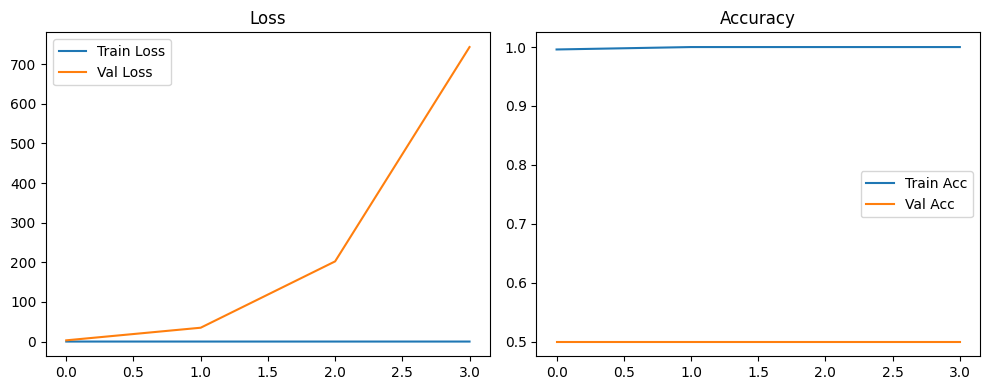

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from scipy.signal import spectrogram
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

# === Spectrogram conversion ===
def waveform_to_spectrogram(waveform, fs=4096, nperseg=256, noverlap=128):
    freqs, times, Sxx = spectrogram(waveform, fs=fs, nperseg=nperseg, noverlap=noverlap)
    Sxx = np.log1p(Sxx)  # log scale
    return Sxx.astype(np.float32)

def batch_to_spectrogram(df):
    specs = []
    for i in range(len(df)):
        waveform = df.iloc[i].values
        spec = waveform_to_spectrogram(waveform)
        specs.append(spec)
    return np.stack(specs)

# === Load data ===
#signal_bbh = pd.read_csv("C:/Users/sunda/Documents/Github/Gravitational Wave Detection/scripts/raw-data-files-enhanced-data-generation/Final_BBH_Merged_Noise_Signal_Reduced_No_ABS.csv", header=None).astype(float)
#noise = pd.read_csv("C:/Users/sunda/Documents/Github/Gravitational Wave Detection/scripts/raw-data-files-enhanced-data-generation/Final_Merged_Noise_Reduced_No_Abs.csv", header=None).astype(float)
#val_signal_bbh = pd.read_csv("C:/Users/sunda/Documents/Github/Gravitational Wave Detection/scripts/raw-val-data-files-enhanced-data-generation/val_Final_BBH_Merged_Noise_Signal_Reduced_No_ABS.csv", header=None).astype(float)
#val_noise = pd.read_csv("C:/Users/sunda/Documents/Github/Gravitational Wave Detection/scripts/raw-val-data-files-enhanced-data-generation/val_Final_Merged_Noise_Reduced_No_Abs.csv", header=None).astype(float)

signal_bbh_df = pd.read_csv("C:/Users/sunda/Documents/Github/Gravitational Wave Detection/scripts/raw-data-files/Final_BBH_Merged_Noise_Signal_Reduced_No_ABS.csv", header=None)
signal_bbh = signal_bbh_df.astype(float)

noise_df = pd.read_csv("C:/Users/sunda/Documents/Github/Gravitational Wave Detection/scripts/raw-data-files/Final_Merged_Noise_Reduced_No_Abs.csv",header = None)
noise = noise_df.astype(float)

val_signal_df = pd.read_csv("C:/Users/sunda/Documents/Github/Gravitational Wave Detection/scripts/raw-val-data-files/val_Final_BBH_Merged_Noise_Signal_Reduced_No_ABS.csv", header = None)
val_signal_bbh = val_signal_df.astype(float)

val_noise_df = pd.read_csv("C:/Users/sunda/Documents/Github/Gravitational Wave Detection/scripts/raw-val-data-files/val_Final_Merged_Noise_Reduced_No_Abs.csv", header = None)
val_noise = val_noise_df.astype(float)

# === Add labels ===
signal_bbh['label'] = 1
noise['label'] = 0
val_signal_bbh['label'] = 1
val_noise['label'] = 0

# === Combine and shuffle ===
train_df = shuffle(pd.concat([signal_bbh, noise], axis=0), random_state=42).reset_index(drop=True)
val_df = shuffle(pd.concat([val_signal_bbh, val_noise], axis=0), random_state=42).reset_index(drop=True)

# === Split features/labels ===
X_train_wave = train_df.iloc[:, :-1]
y_train = train_df.iloc[:, -1].astype(np.float32)
X_val_wave = val_df.iloc[:, :-1]
y_val = val_df.iloc[:, -1].astype(np.float32)

# === Standardize ===
scaler = StandardScaler()
X_train_wave = pd.DataFrame(scaler.fit_transform(X_train_wave))
X_val_wave = pd.DataFrame(scaler.transform(X_val_wave))

# === Convert to spectrograms ===
X_train = batch_to_spectrogram(X_train_wave)
X_val = batch_to_spectrogram(X_val_wave)

# === Add channel dimension ===
X_train = X_train[..., np.newaxis]
X_val = X_val[..., np.newaxis]

# === Model ===
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=X_train.shape[1:]),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# === Train ===
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    batch_size=64,
                    epochs=20,
                    callbacks=[early_stop])

# === Evaluate ===
loss, acc = model.evaluate(X_val, y_val)
print(f"\n✅ Validation Accuracy: {acc * 100:.2f}%")

# === Plot ===
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend(); plt.title("Loss")

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend(); plt.title("Accuracy")
plt.tight_layout()
plt.show()


In [ ]:
from pycbc import distributions
from pycbc.waveform import get_td_waveform, td_approximants
from pycbc.detector import Detector
import matplotlib.pyplot as plt
import numpy as np
import gwpy
import pylab
from tqdm.notebook import tqdm
from pycbc.types import TimeSeries  
import pandas as pd
import os
import csv
import pycbc.noise
import pycbc.psd
from pycbc.filter import matched_filter
from pycbc.psd import aLIGOZeroDetHighPower
from pycbc.noise import noise_from_psd
from pycbc.waveform.utils import taper_timeseries
from pycbc.filter import highpass



for i in tqdm(range(n_samples), desc="Generating BBH dataset"):
    target_snr = np.random.randint(8, 15)

    # Generate BBH waveform
    hp, _ = get_td_waveform(approximant="SEOBNRv2",
                            mass1=bbh_two_mass_samples[i][0],
                            mass2=bbh_two_mass_samples[i][1],
                            delta_t=1.0 / 4096,
                            f_lower=40)

    flow = 30.0

    # ❗ Problem: Using the same PSD for both sigma() and noise_from_psd() fails due to delta_f mismatch
    # ✅ Fix: Use two separate PSDs — one matching hp.duration for sigma(), one fixed for noise

    # PSD for SNR scaling — must match the waveform's duration (delta_f = 1 / duration)
    delta_f_sigma = 1.0 / hp.duration
    flen_sigma = int(2048 / delta_f_sigma) + 1
    psd_for_sigma = aLIGOZeroDetHighPower(flen_sigma, delta_f_sigma, flow)
    psd_for_sigma[psd_for_sigma == 0] = 1e-40
    psd_for_sigma = pycbc.types.FrequencySeries(psd_for_sigma, delta_f=delta_f_sigma)

    # Convert to frequency domain and compute original SNR
    ht = hp.to_frequencyseries()
    snr_before = sigma(ht, psd=psd_for_sigma, low_frequency_cutoff=40)

    # Scale waveform to target SNR
    hp *= target_snr / snr_before

    # Convert to GWPy TimeSeries and apply random injection time offset
    bbh_signal = TimeSeries.from_pycbc(hp)
    st1 = np.random.randint(0, len(start_times_bbh))
    bbh_signal.t0 = start_times_bbh[st1]

    # PSD for noise generation — fixed delta_f for 4s segment
    delta_f_noise = 1.0 / 4.0  # 4-second window => delta_f = 0.25
    flen_noise = int(2048 / delta_f_noise) + 1
    psd_for_noise = aLIGOZeroDetHighPower(flen_noise, delta_f_noise, flow)

    # Generate noise with delta_t = 1/4096 for 4 seconds
    delta_t = 1.0 / 4096
    tsamples = int(4 / delta_t)
    noise = pycbc.noise.noise_from_psd(tsamples, delta_t, psd_for_noise)
    
    noise = TimeSeries.from_pycbc(noise)

    # Inject signal into noise
    injected = noise.inject(bbh_signal)

    # Save to files
    bbh_signal.write(dirs["signal"] + f"bbh_4k_{i}.txt")
    injected.write(dirs["injected"] + f"merged_noise_signal_{i}.txt")


Great question. Your current data generation pipeline is functional and quite solid as a base. But to **improve realism, training performance, and scientific validity**, here are **10 concrete improvements** I recommend, grouped into three categories:

---

## 🧪 SCIENTIFIC REALISM IMPROVEMENTS

### 1. 🎯 **Inject at Target SNR Instead of Arbitrary Scaling**

Currently, you're doing:

```python
bbh_signal = (bbh_signal / max(abs(bbh_signal))) * 0.2
```

But that leads to arbitrary amplitude scaling, not a physically meaningful signal-to-noise ratio (SNR).

✅ **Instead**, use PyCBC’s `pycbc.filter.sigma()` to scale the signal to a target optimal SNR:

```python
from pycbc.filter import sigma

# Calculate scaling factor
sig = sigma(hp, psd=psd, low_frequency_cutoff=40)
scaling = target_snr / sig
hp *= scaling
```

This makes each injection consistent with your declared `target_snr = 8`.

---

### 2. 📡 **Inject into Real LIGO Noise Instead of Simulated Noise**

You're generating synthetic Gaussian noise using `noise_from_psd`, but real LIGO data has:

* Glitches
* Spectral lines
* Instrumental artifacts

✅ Use real noise from the GWOSC open data:

```python
from pycbc.frame import query_and_read_frame
strain = query_and_read_frame('H1', gps_start, gps_end, channel_name='H1:GWOSC-4KHZ_R1_STRAIN')
```

This gives your ML model real-world complexity to handle.

---

### 3. 🌀 **Use Multiple Detectors (H1, L1, V1)**

Currently you're using a single channel. Real GW detection uses networks of detectors.

✅ Inject signals into 3 channels (H1, L1, V1), possibly with time delays and antenna pattern effects:

```python
from pycbc.detector import Detector

det = Detector('H1')
dt = det.time_delay_from_earth_center(ra, dec, time)
```

---

## 🧠 MACHINE LEARNING DATA QUALITY IMPROVEMENTS

### 4. 🎛️ **Save in NumPy or HDF5 Format**

Text files are very slow to read for training.

✅ Instead:

```python
np.save(f"{path}/signal_{i}.npy", bbh_signal.value)
```

or use `h5py` to store signal, noise, metadata in one file.

---

### 5. 🌈 **Generate Spectrograms Instead of Raw Waveforms**

CNNs perform better on time-frequency images (like in [G2Net](https://www.kaggle.com/competitions/g2net-gravitational-wave-detection)).

✅ Use Short-Time Fourier Transform (STFT) or wavelets:

```python
from scipy.signal import spectrogram
f, t, Sxx = spectrogram(bbh_signal, fs=4096, nperseg=256)
```

---

### 6. 🧪 **Add Metadata to Each Sample**

Currently, no labels or context are saved.

✅ Save:

* `mass1`, `mass2`
* `SNR`
* `injection_time`
* `signal_class`: signal vs. noise

In a CSV or as metadata in `.hdf5`.

---

### 7. 💡 **Include Glitches or Other Non-GW Signals**

Add “mimickers” to force your model to learn finer distinctions.

✅ You can simulate glitches or use real glitch examples from the Gravity Spy dataset.

---

## ⚡ EFFICIENCY & CODE STRUCTURE IMPROVEMENTS

### 8. 🔁 **Vectorize or Parallelize Dataset Generation**

Currently runs sequentially and slowly.

✅ Use multiprocessing:

```python
from multiprocessing import Pool
with Pool(processes=4) as pool:
    pool.map(generate_sample, range(n_samples))
```

---

### 9. 📦 **Wrap the Logic in Functions or Classes**

Your script is procedural; wrapping in functions will improve reuse and modularity:

```python
def generate_bbh_sample(index, target_snr, psd, ...):
    ...
    return signal, noise, injected
```

---

### 10. 🧹 **Save Logs and Error Files**

When generating thousands of files, track:

* Which files failed (e.g., empty waveform, injection error)
* Metadata CSV of all generated signals for traceability

---

## 🧠 Final Thoughts

If your goal is ML classification of GW signals:

* Improvements #1, #4, #5, #6, #8 are **must-have**
* \#2, #3, #7 add **realism and robustness**
* \#9, #10 help in **scaling and reproducibility**

---

Let me know which of these you want help implementing, and I’ll build the code step-by-step with you.
